# Compensation factor measurement

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os.path as op
from pprint import pprint as pp
import scipy.stats
import seaborn as sns

In [3]:
datapath = "~/teigen_data/output_rows.csv"

In [4]:
plotkw ={
    "figsize": [9, 6], 
    # "fontsize": 14
}

In [52]:

df = pd.read_csv(op.expanduser(datapath))
df["surface error [mm^2]"] = df["numeric surface [mm^2]"] - df["surface [mm^2]"]
df["surface error [%]"] = df["surface error [mm^2]"] / df["surface [mm^2]"] * 100
df["volume error [mm^3]"] = df["numeric volume [mm^3]"] - df["volume [mm^3]"]
df["volume error [%]"] = df["volume error [mm^3]"] / df["volume [mm^3]"] * 100
df["measurement_resolution"] = df["postprocessing measurement_resolution"]
df["length_distribution_mean"] = df["generators Unconnected tubes length_distribution_mean"]


# Estimate radius from volume and surface


$$ r_0 r_c = \frac{1}{2} \sqrt{\frac{S}{\pi}}$$ 
$$ r_0 r_c = \sqrt[3]{\frac{3 V}{4 \pi}}$$ 

/Users/mjirik/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


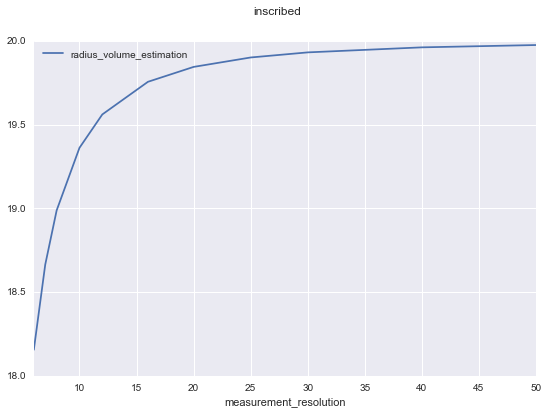

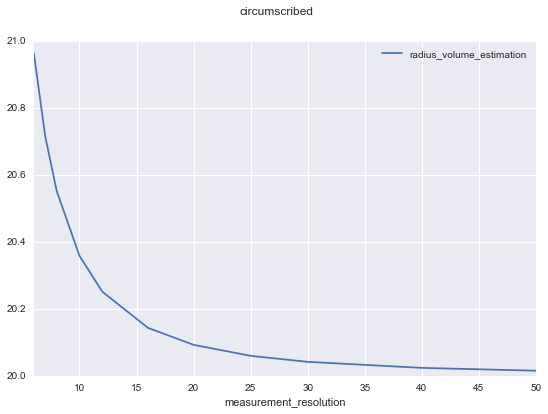

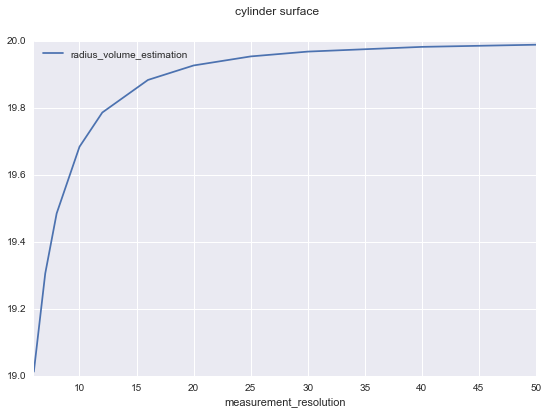

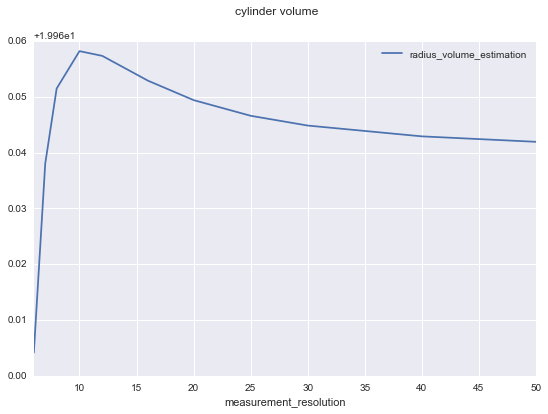

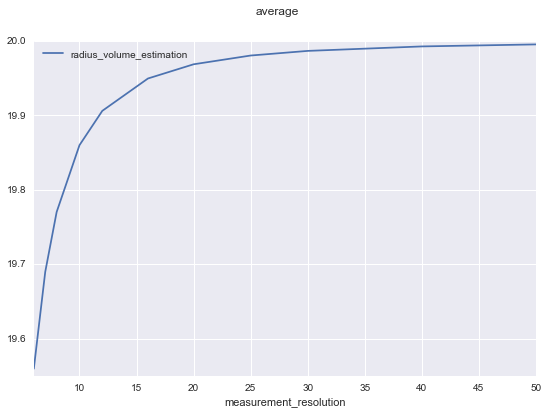

In [6]:
for radius_method in ["inscribed", "circumscribed", "cylinder surface", "cylinder volume", "average"]:
        
    dfs = df[
        df["output note"] == "compensation method 1 sphere " + radius_method
        # df["generators Unconnected cylinders radius_distribution_mean"] == 5 
    ]
    
    dfs["radius_volume_estimation"] = (3 * dfs["numeric volume [mm^3]"] / (4* np.pi))**(1.0/3.0)
    dfsp = dfs[["radius_volume_estimation", "measurement_resolution"]].sort_values(
        "measurement_resolution")
    
    fig = plt.figure(figsize=[25, 18])
    ax = plt.subplot(111)
    dfsp.plot(
        ax=ax, x="measurement_resolution", **plotkw)
    # ax = plt.subplot(122)
    # dfsp[["volume error [%]"]].plot(
    #     ax=ax, kind="box", **plotkw)
    plt.suptitle(radius_method)


/Users/mjirik/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mjirik/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


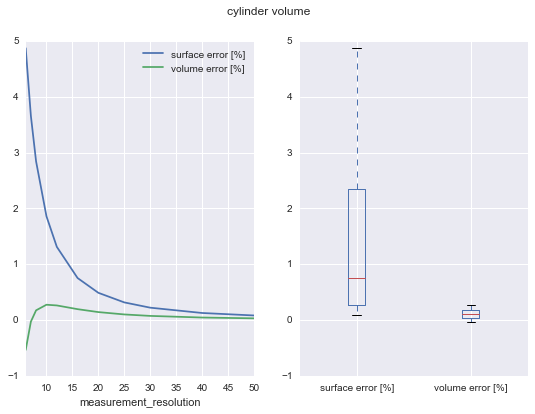

In [29]:
## Interpolate

radius_method = "cylinder volume"
dfs = df[
    df["output note"] == "compensation method 1 sphere " + radius_method
    # df["generators Unconnected cylinders radius_distribution_mean"] == 5 
]

dfs["radius_volume_estimation_numeric"] = ((3 * dfs["numeric volume [mm^3]"] / (4* np.pi))**(1.0/3.0))
dfs["radius_volume_estimation"] = ((3 * dfs["volume [mm^3]"] / (4* np.pi))**(1.0/3.0))
dfs["radius_surface_estimation_numeric"] = ((dfs["numeric surface [mm^2]"] / (4 * np.pi))**(.5))
dfs["radius_surface_estimation"] = ((dfs["volume [mm^3]"] / (4* np.pi))**(.5))
dfsp = dfs[["surface error [%]", "volume error [%]", "measurement_resolution"]].sort_values(
    "measurement_resolution")

fig = plt.figure(figsize=[25, 18])
ax = plt.subplot(121)
dfsp.plot(
    ax=ax, x="measurement_resolution", **plotkw)
ax = plt.subplot(122)
dfsp[["surface error [%]", "volume error [%]"]].plot(
    ax=ax, kind="box", **plotkw)
plt.suptitle(radius_method)

## Volume

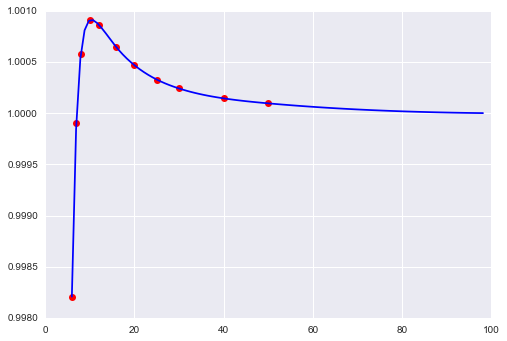

In [32]:
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
x = list(dfs["measurement_resolution"])
y = list(dfs["radius_volume_estimation_numeric"] / dfs["radius_volume_estimation"])

x.append(100)
y.append(1.0)

x.append(200)
y.append(1.0)

x = np.asarray(x)
y = np.asarray(y)
spl1 = InterpolatedUnivariateSpline(x, y)
# spl1.set_smoothing_factor(0.1)
xs = np.linspace(6, 100, 100)

plt.figure()
plt.plot(x[:-2], y[:-2], "ro")
plt.plot(xs[:-2], spl1(xs[:-2]), "b")
plt.show()
print x
print y

In [9]:
print x
print y

[   6    7    8   10   12   16   20   25   30   40   50 1000]
[ 0.99820681  0.99990171  1.00057384  1.00090875  1.00086617  1.00064401
  1.00046984  1.00032942  1.00024186  1.00014509  1.00009627  1.        ]


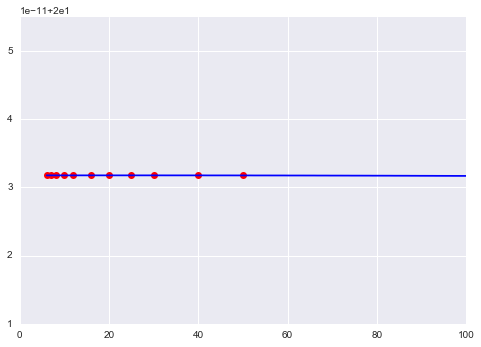

In [33]:
import scipy
import copy
# f = scipy.interpolate.interp1d(x,y, kind="quadratic", fill_value="extrapolate")
x = np.asarray(list(dfs["measurement_resolution"]))
y = np.asarray(list(dfs["radius_volume_estimation"]))

z = np.polyfit(x,y, 2)
f = np.poly1d(z)
plt.plot(x, y, "ro")
plt.plot(xs, f(xs), "b")
plt.show()

[  2.90717080e+10   5.03421286e+09   2.00000000e+01   9.68492196e-04
   6.27742534e+00  -1.64529573e+00]


/Users/mjirik/miniconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


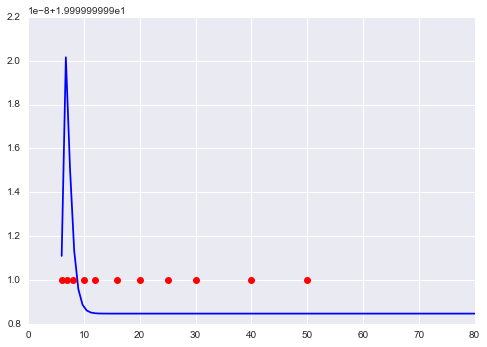

In [11]:
from scipy.optimize import curve_fit
    
def func(x, a, b, c, e, f, g):
    return a*np.exp(-b * x) + c + np.sin(e*x + f) * np.exp(g*x)



def func1(x, theta, omega0, K):
    jmt = (1 - theta**2)**0.5
    out = K * (1 - 1/jmt * np.exp(-1 * theta * omega0 * x))
    # out = K * (1 - (1 / jmt * np.exp(-1 * theta * omega0 * x)) * np.sin(omega0 * jmt * x)) 
    #+ np.arccos(theta))
    return out

x = np.asarray(list(dfs["measurement_resolution"]))
y = np.asarray(list(dfs["radius_volume_estimation"]))

popt, pcov = curve_fit(func, x, y, bounds=(-np.inf, np.inf))
print popt

plt.plot(xs, func(xs, *popt), "b")
plt.plot(x, y, "ro")
plt.show()

## Surface

/Users/mjirik/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mjirik/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mjirik/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

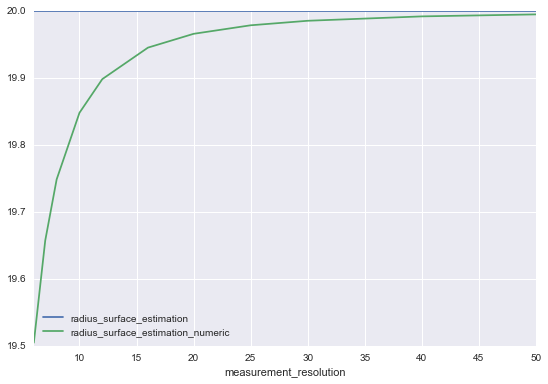

In [45]:

radius_method = "cylinder surface"
dfs = df[
    df["output note"] == "compensation method 1 sphere " + radius_method
    # df["generators Unconnected cylinders radius_distribution_mean"] == 5 
]

dfs["radius_volume_estimation_numeric"] = ((3 * dfs["numeric volume [mm^3]"] / (4* np.pi))**(1.0/3.0))
dfs["radius_volume_estimation"] = ((3 * dfs["volume [mm^3]"] / (4* np.pi))**(1.0/3.0))
dfs["radius_surface_estimation_numeric"] = ((dfs["numeric surface [mm^2]"] / (4 * np.pi))**(.5))
dfs["radius_surface_estimation"] = ((dfs["surface [mm^2]"] / (4* np.pi))**(.5))

dfsp = dfs[["radius_surface_estimation", "radius_surface_estimation_numeric", "measurement_resolution"]]
dfsp.plot(
    x="measurement_resolution", **plotkw)

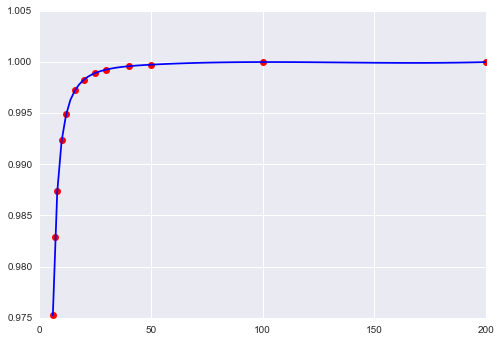

x = [6, 7, 8, 10, 12, 16, 20, 25, 30, 40, 50, 100, 200, ]
y = 0.97522857799, 0.982858482408, 0.987423696432, 0.99239757445, 0.994910515802, 0.997261880581, 0.998292863128, 0.998929760493, 0.999266886531, 0.999594545757, 0.999743129653, 1.0, 1.0, ]


In [51]:
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
x = list(dfs["measurement_resolution"])
y = list(dfs["radius_surface_estimation_numeric"] / dfs["radius_surface_estimation"])

x.append(100)
y.append(1.0)

x.append(200)
y.append(1.0)

x = np.asarray(x)
y = np.asarray(y)
spl1 = InterpolatedUnivariateSpline(x, y)
# spl1.set_smoothing_factor(0.1)
xs = np.linspace(6, 200, 100)

plt.figure()
plt.plot(x[:], y[:], "ro")
plt.plot(xs[:], spl1(xs[:]), "b")
plt.show()
stx = "x = ["
for i in x:
    stx = stx + str(i) + ", "
stx += "]"
sty = "y = "
for i in y:
    sty = sty + str(i) + ", "
sty += "]"
print stx
print sty

In [37]:
x

array([100, 200])

# Simple check - this computes selected radius from data

/Users/mjirik/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


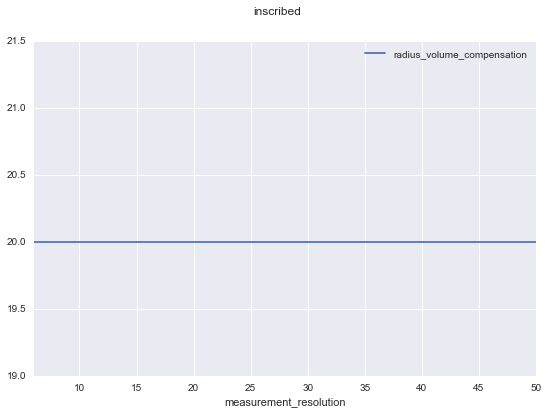

In [12]:
# just for control - this should be exactly same as selected radius
radius_method = "inscribed"
dfs = df[
    df["output note"] == "compensation method 1 sphere " + radius_method
    # df["generators Unconnected cylinders radius_distribution_mean"] == 5 
]

dfs["radius_volume_compensation"] = (3 * dfs["volume [mm^3]"] / (4* np.pi))**(1.0/3.0)
dfsp = dfs[["radius_volume_compensation", "measurement_resolution"]].sort_values(
    "measurement_resolution")

fig = plt.figure(figsize=[25, 18])
ax = plt.subplot(111)
dfsp.plot(
    ax=ax, x="measurement_resolution", **plotkw)
plt.suptitle(radius_method)